# lightgbm 

[95.17237377166748] Finished to load data
[143.7321412563324] Start to generate time features
[173.45271229743958] Start LGBoost Training
preparing validation datasets


C:\Users\osk\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\osk\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 25 rounds.
[10]	train's auc: 0.952935	valid's auc: 0.95318
[20]	train's auc: 0.956854	valid's auc: 0.956391
[30]	train's auc: 0.961457	valid's auc: 0.960804
[40]	train's auc: 0.962984	valid's auc: 0.962265
[50]	train's auc: 0.964861	valid's auc: 0.963554
[60]	train's auc: 0.966453	valid's auc: 0.964821
[70]	train's auc: 0.967582	valid's auc: 0.965631
[80]	train's auc: 0.968649	valid's auc: 0.966034
[90]	train's auc: 0.969408	valid's auc: 0.966508
[100]	train's auc: 0.970175	valid's auc: 0.966895
[110]	train's auc: 0.970688	valid's auc: 0.9673
[120]	train's auc: 0.971141	valid's auc: 0.967641
[130]	train's auc: 0.971606	valid's auc: 0.967921
[140]	train's auc: 0.971958	valid's auc: 0.968068
[150]	train's auc: 0.972276	valid's auc: 0.968235
[160]	train's auc: 0.972584	valid's auc: 0.968387
[170]	train's auc: 0.972849	valid's auc: 0.968544
[180]	train's auc: 0.973106	valid's auc: 0.968733
[190]	train's auc: 0.973322	valid's auc: 0.96884
[

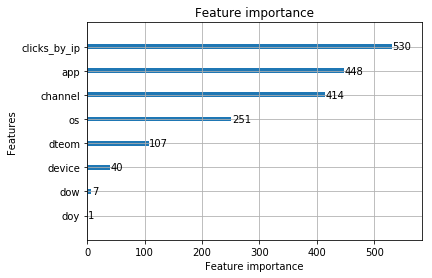

In [7]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Change this for validation with 10% from train
is_valid = False

# Check directories
from pathlib import Path
path = '../input/'
modelpath = '../model/'
subpath = '../sub/'
picpath = '../pic/'
directories = [path, modelpath, subpath, picpath]
for p in directories:
    if not(Path(p).is_dir()):
        Path(p).mkdir()

def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df['doy']      = df["datetime"].dt.dayofyear
    df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df['doh']      = df['datetime'].dt.hour.astype('uint8')
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

def lgb_modelfit_nocv(params, dtrain, dtrainlabel, dvalid, dvalidlabel, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=300, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain.values, label=dtrainlabel.values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid.values, label=dvalidlabel.values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1


# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv(path+"train.csv", skiprows=range(1,123903891), nrows=61000000, usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

# Drop IP and ID from test rows
sub = pd.DataFrame()
#sub['click_id'] = test['click_id'].astype('int')
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()

# Count the number of clicks by ip
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

train = merge[:nrow_train]
test = merge[nrow_train:]

del test, merge
gc.collect()

print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()

print('[{}] Start LGBoost Training'.format(time.time() - start_time))

# Set the params(this params from Pranav kernel) for lgboost model
params = {
    'learning_rate': 0.1,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99 # because training data is extremely unbalanced 
}      

predictors = ['app', 'device', 'os', 'channel', 'clicks_by_ip', 'dow', 'doy', 'doh', 'dteom']
categorical = ['app', 'device', 'os', 'channel', 'clicks_by_ip', 'dow', 'doy', 'doh', 'dteom']
target = 'is_attributed'
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
del train, y
gc.collect()

model = lgb_modelfit_nocv(params, 
                        x1,
                        y1,
                        x2,
                        y2,
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=25, 
                        verbose_eval=True, 
                        num_boost_round=300, 
                        categorical_features=categorical)

del x1, x2, y1, y2
gc.collect()
print('[{}] Finish LGBoost Training'.format(time.time() - start_time))

# date for filename
from datetime import datetime as dt
datetime = dt.now().strftime('_%Y_%m%d_%H%M_%S')

# Plot the feature importance from lgboost
lgb.plot_importance(model)
plt.gcf().savefig(picpath + 'feature_importance_lgb' + datetime + '.png')

# Load the test for predict 
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

sub['click_id'] = test['click_id'].astype('int')

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

# Save the predictions
sub['is_attributed'] = model.predict(test)
subname = subpath + 'lgb_sub' + datetime + '.csv'
sub.to_csv(subname, float_format='%.8f', index=False)

# Save the model
modelname = modelpath + 'lgbmodel' + datetime + '.model'
model.save_model(modelname)
